In [91]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout,GRU
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from tensorflow.keras import optimizers, Model
import matplotlib.pyplot as plt
import math

# Load Data

In [92]:
import os
CURR_FOLDER_PATH = os.getcwd()
BASE_PATH = os.path.dirname(os.path.dirname(CURR_FOLDER_PATH))
DATA_PATH = os.path.join(BASE_PATH, 'Lulus/data')

In [93]:
df = pd.read_excel(DATA_PATH + '/Hargalagpasartradisionallagvariable.xlsx')
# Data yang digunakan yaitu Harga cabai Rawit dan Harga Bawang putih sebagai Barang Subtitusi Sudah dilakukan lag - 1 Minggu

In [94]:
df

,Tanggal,Harga Bawang Putih,Harga Cabai Merah,Harga Cabai Rawit
0,01/ 01/ 2018,-,-,-
1,08/ 01/ 2018,-,38300,-
2,15/ 01/ 2018,24300,42800,42600
3,22/ 01/ 2018,24200,37850,42700
4,29/ 01/ 2018,23100,38950,42600
...,...,...,...,...
308,27/ 11/ 2023,37450,80250,76600
309,04/ 12/ 2023,37600,94900,79150
310,11/ 12/ 2023,37200,99300,79100
311,18/ 12/ 2023,38050,85000,75550


# Statistical Analytics

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Tanggal             313 non-null    object
 1   Harga Bawang Putih  313 non-null    object
 2   Harga Cabai Merah   313 non-null    object
 3   Harga Cabai Rawit   313 non-null    object
dtypes: object(4)
memory usage: 9.9+ KB


In [96]:
df.shape

(313, 4)

In [97]:
df.replace('-', pd.NA, inplace=True)

In [98]:
missing_values = df.isnull().sum()
percentage_missing = (missing_values / df.shape[0]) * 100
print("Jumlah Missing Value per Kolom:")
print(missing_values)
print("\nPersentase Missing Value per Kolom:")
percentage_missing

Jumlah Missing Value per Kolom:
Tanggal               0
Harga Bawang Putih    9
Harga Cabai Merah     9
Harga Cabai Rawit     9
dtype: int64

Persentase Missing Value per Kolom:


Tanggal               0.000000
Harga Bawang Putih    2.875399
Harga Cabai Merah     2.875399
Harga Cabai Rawit     2.875399
dtype: float64

In [99]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/ %m/ %Y')
df['Bulan'] = df['Tanggal'].dt.to_period('M')
mean_values = df.groupby('Bulan').mean()


def fill_missing_with_mean(row):
    if pd.isna(row['Harga Bawang Putih']):
        row['Harga Bawang Putih'] = mean_values.loc[row['Bulan'], 'Harga Bawang Putih']
    if pd.isna(row['Harga Cabai Merah']):
        row['Harga Cabai Merah'] = mean_values.loc[row['Bulan'], 'Harga Cabai Merah']
    if pd.isna(row['Harga Cabai Rawit']):
        row['Harga Cabai Rawit'] = mean_values.loc[row['Bulan'], 'Harga Cabai Rawit']
    return row


df = df.apply(fill_missing_with_mean, axis=1)
print(df)

       Tanggal  Harga Bawang Putih  Harga Cabai Merah  Harga Cabai Rawit  \
0   2018-01-01        23866.666667       39475.000000       42633.333333   
1   2018-01-08        23866.666667       38300.000000       42633.333333   
2   2018-01-15        24300.000000       42800.000000       42600.000000   
3   2018-01-22        24200.000000       37850.000000       42700.000000   
4   2018-01-29        23100.000000       38950.000000       42600.000000   
..         ...                 ...                ...                ...   
308 2023-11-27        37450.000000       80250.000000       76600.000000   
309 2023-12-04        37600.000000       94900.000000       79150.000000   
310 2023-12-11        37200.000000       99300.000000       79100.000000   
311 2023-12-18        38050.000000       85000.000000       75550.000000   
312 2023-12-25        39050.000000       93066.666667       66350.000000   

       Bulan  
0    2018-01  
1    2018-01  
2    2018-01  
3    2018-01  
4    2018-01

In [100]:
df['Harga Cabai Merah'] = df['Harga Cabai Merah'].astype('float64')
df['Harga Bawang Putih'] = df['Harga Bawang Putih'].astype('float64')
df['Harga Cabai Rawit'] = df['Harga Cabai Rawit'].astype('float64')

In [101]:
import seaborn as sns

harga_merah_stats = df['Harga Cabai Merah'].describe()
print("\nStatistik Deskriptif Harga Cabai Merah:")
print(harga_merah_stats)

harga_putih_stats = df['Harga Bawang Putih'].describe()
print("\nStatistik Deskriptif Harga Bawang Putih:")
print(harga_putih_stats)

harga_rawit_stats = df['Harga Cabai Rawit'].describe()
print("\nStatistik Deskriptif Harga Cabai Rawit:")
print(harga_rawit_stats)



Statistik Deskriptif Harga Cabai Merah:
count       313.000000
mean      43092.092652
std       15493.651894
min       21750.000000
25%       31650.000000
50%       40800.000000
75%       49550.000000
max      109450.000000
Name: Harga Cabai Merah, dtype: float64

Statistik Deskriptif Harga Bawang Putih:
count      313.000000
mean     31311.648030
std       6546.352059
min      22400.000000
25%      27600.000000
50%      28700.000000
75%      34400.000000
max      73900.000000
Name: Harga Bawang Putih, dtype: float64

Statistik Deskriptif Harga Cabai Rawit:
count       313.000000
mean      44877.715655
std       17241.023349
min       22600.000000
25%       30950.000000
50%       42000.000000
75%       54250.000000
max      100750.000000
Name: Harga Cabai Rawit, dtype: float64


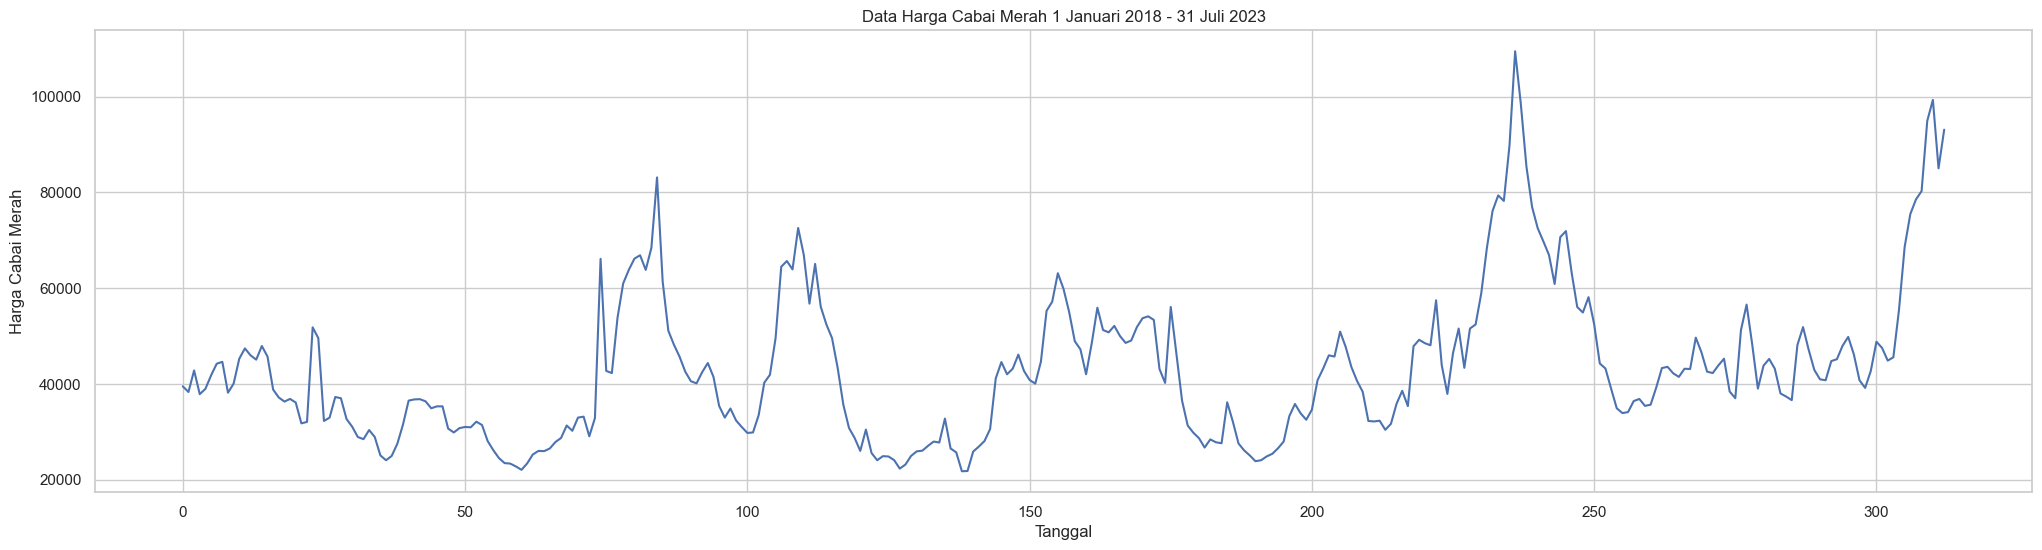

In [102]:
# Visualisasi
plt.figure(figsize=(25, 6))
plt.plot(df.index, df['Harga Cabai Merah'])
plt.title('Data Harga Cabai Merah 1 Januari 2018 - 31 Juli 2023')
plt.xlabel('Tanggal')
plt.ylabel('Harga Cabai Merah')
plt.show()

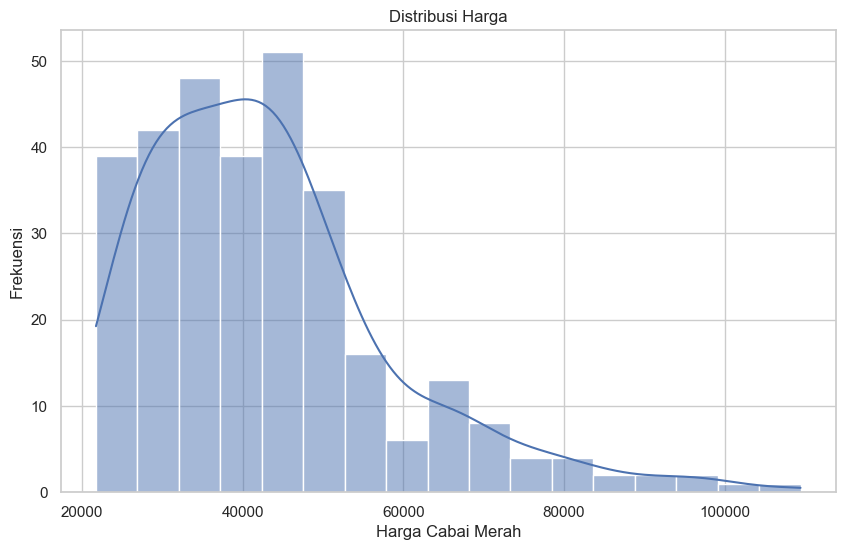

In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Harga Cabai Merah'], kde=True)
plt.title('Distribusi Harga')
plt.xlabel('Harga Cabai Merah')
plt.ylabel('Frekuensi')
plt.show()

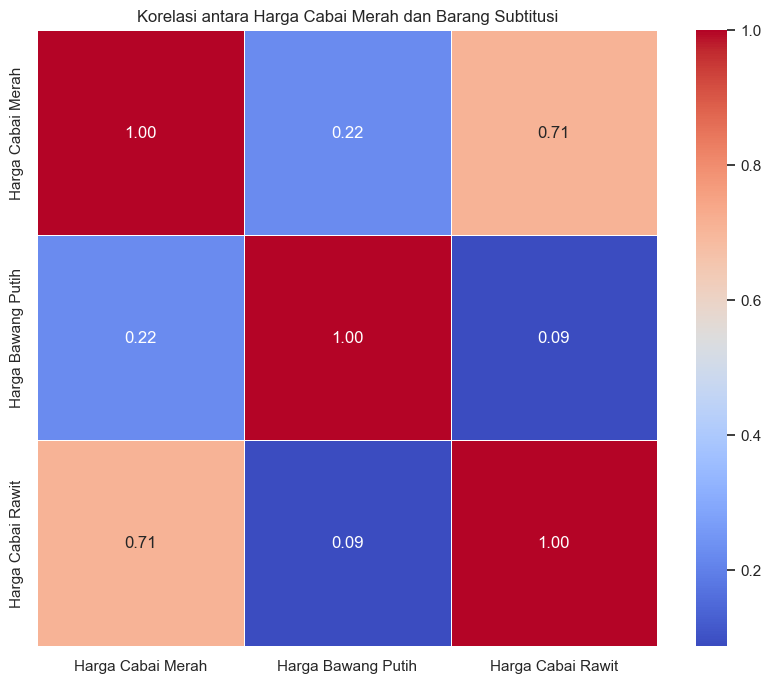

In [104]:
corr_with_target = df[['Harga Cabai Merah','Harga Bawang Putih','Harga Cabai Rawit']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Korelasi antara Harga Cabai Merah dan Barang Subtitusi')
plt.show()

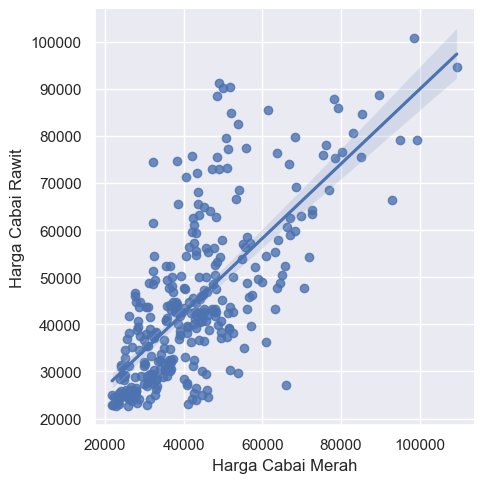

In [105]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
df.head()
sns.lmplot(x="Harga Cabai Merah", y="Harga Cabai Rawit", data=df)
plt.show()

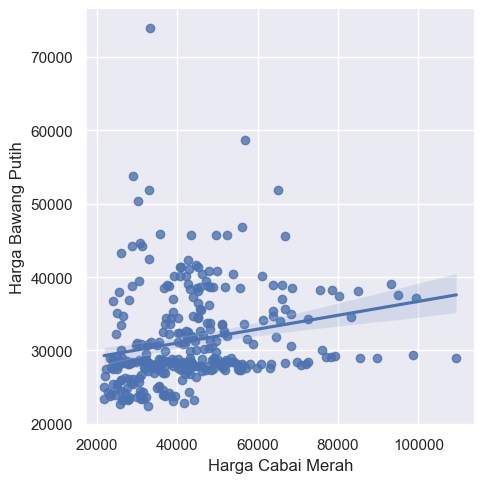

In [106]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
df.head()
sns.lmplot(x="Harga Cabai Merah", y="Harga Bawang Putih", data=df)
plt.show()

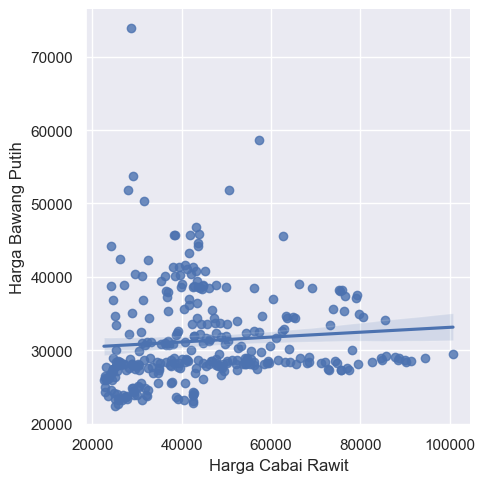

In [107]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
df.head()
sns.lmplot(x="Harga Cabai Rawit", y="Harga Bawang Putih", data=df)
plt.show()

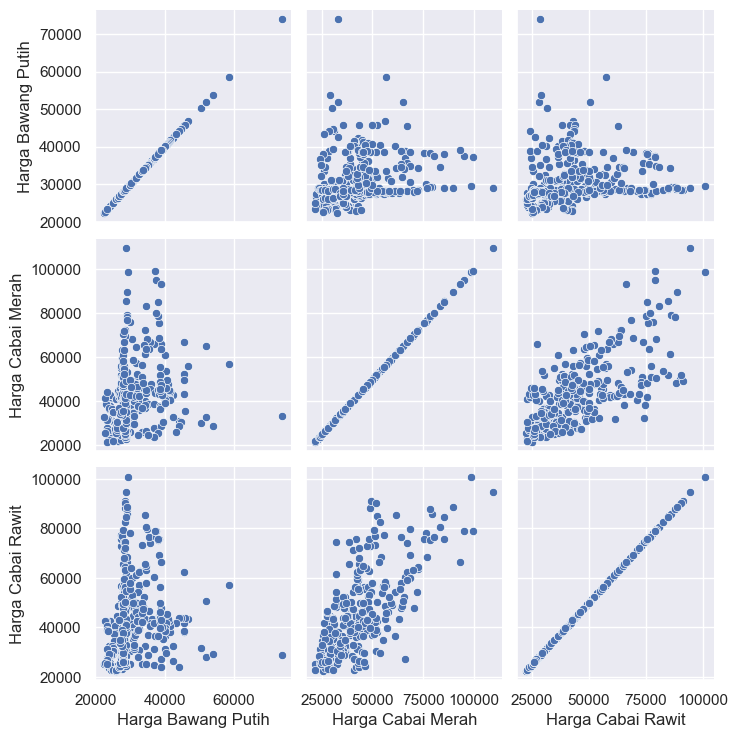

In [108]:
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.pairplot(df, diag_kind=None)
plt.show()

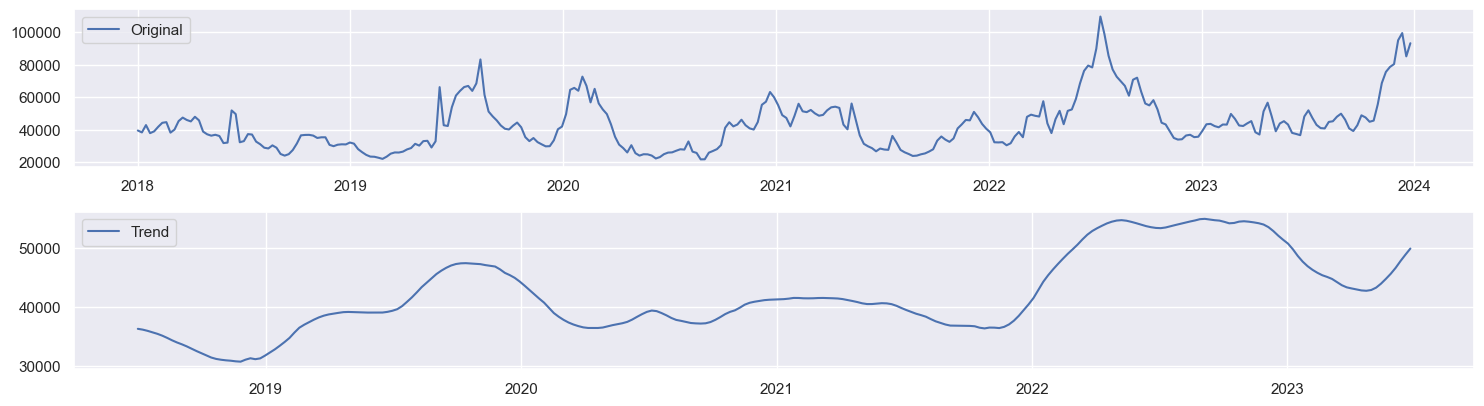

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ubah kolom 'Tanggal' menjadi tipe datetime dan tetapkan sebagai indeks
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
df.set_index('Tanggal', inplace=True)

# Melakukan dekomposisi musiman
decomposition = seasonal_decompose(df['Harga Cabai Merah'], model='additive')

# Menampilkan hasil
plt.figure(figsize=(15, 8))

# Data asli
plt.subplot(411)
plt.plot(df.index, df['Harga Cabai Merah'], label='Original')
plt.legend(loc='upper left')

# Trend
plt.subplot(412)
plt.plot(decomposition.trend.index, decomposition.trend, label='Trend')
plt.legend(loc='upper left')


plt.tight_layout()
plt.show()


# Preprocessing Data


In [110]:
scaler_rr = MinMaxScaler(feature_range=(0, 1))
scaler_harga = MinMaxScaler(feature_range=(0, 1))
df['Harga Cabai Merah_Scaled'] = scaler_harga.fit_transform(df[['Harga Cabai Merah']])
df['Harga Bawang Putih_Scaled'] = scaler_rr.fit_transform(df[['Harga Bawang Putih']])
df['Harga Cabai Rawit_Scaled'] = scaler_rr.fit_transform(df[['Harga Cabai Rawit']])

In [111]:
df.head()

,Harga Bawang Putih,Harga Cabai Merah,Harga Cabai Rawit,Bulan,Harga Cabai Merah_Scaled,Harga Bawang Putih_Scaled,Harga Cabai Rawit_Scaled
Tanggal,,,,,,,
2018-01-01,23866.666667,39475.0,42633.333333,2018-01,0.202109,0.028479,0.256345
2018-01-08,23866.666667,38300.0,42633.333333,2018-01,0.188712,0.028479,0.256345
2018-01-15,24300.000000,42800.0,42600.000000,2018-01,0.240023,0.036893,0.255918
2018-01-22,24200.000000,37850.0,42700.000000,2018-01,0.183580,0.034951,0.257198
2018-01-29,23100.000000,38950.0,42600.000000,2018-01,0.196123,0.013592,0.255918


# Split Data

In [128]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.model_selection import train_test_split

selected_columns = ['Harga Cabai Merah_Scaled']
df=df[selected_columns]
# Assuming trainX, train, and test are already defined

# Define ARIMA model parameters
p = 5  # AR order
d = 3  # differencing order
q = 0  # MA order

# Define exogenous variables
exog_train = train[['Harga Cabai Merah_Scaled']].values
exog_test = test[['Harga Cabai Merah_Scaled']].values

# Initialize ARIMA model
model = ARIMA(train['Harga Cabai Merah_Scaled'], exog=exog_train, order=(p, d, q))

# Fit the ARIMA model
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test), exog=exog_test)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test['Harga Cabai Merah_Scaled'], forecast)

print("Mean Absolute Percentage Error (MAPE):", mape)


c:\Users\ihsan\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\ihsan\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\ihsan\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Mean Absolute Percentage Error (MAPE): 0.0001258770250471995


c:\Users\ihsan\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
predictions = model.predict(testX)
predictions = scaler_harga.inverse_transform(predictions)
testY = scaler_harga.inverse_transform(testY)

2/2 [==============================] - 1s 5ms/step


In [ ]:
trainY = scaler_harga.inverse_transform(trainY)

In [119]:
df_test = pd.DataFrame({'Actual': np.squeeze(test), 'Predicted': np.squeeze(forecast)})
df_test.head(30)

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [ ]:
#df['Tanggal'] = pd.to_datetime(df['Tanggal'])
#df.set_index('Tanggal', inplace=True)
#df.sort_index(inplace=True)
#df.index = pd.to_datetime(df.index)

# Hasil Akhir

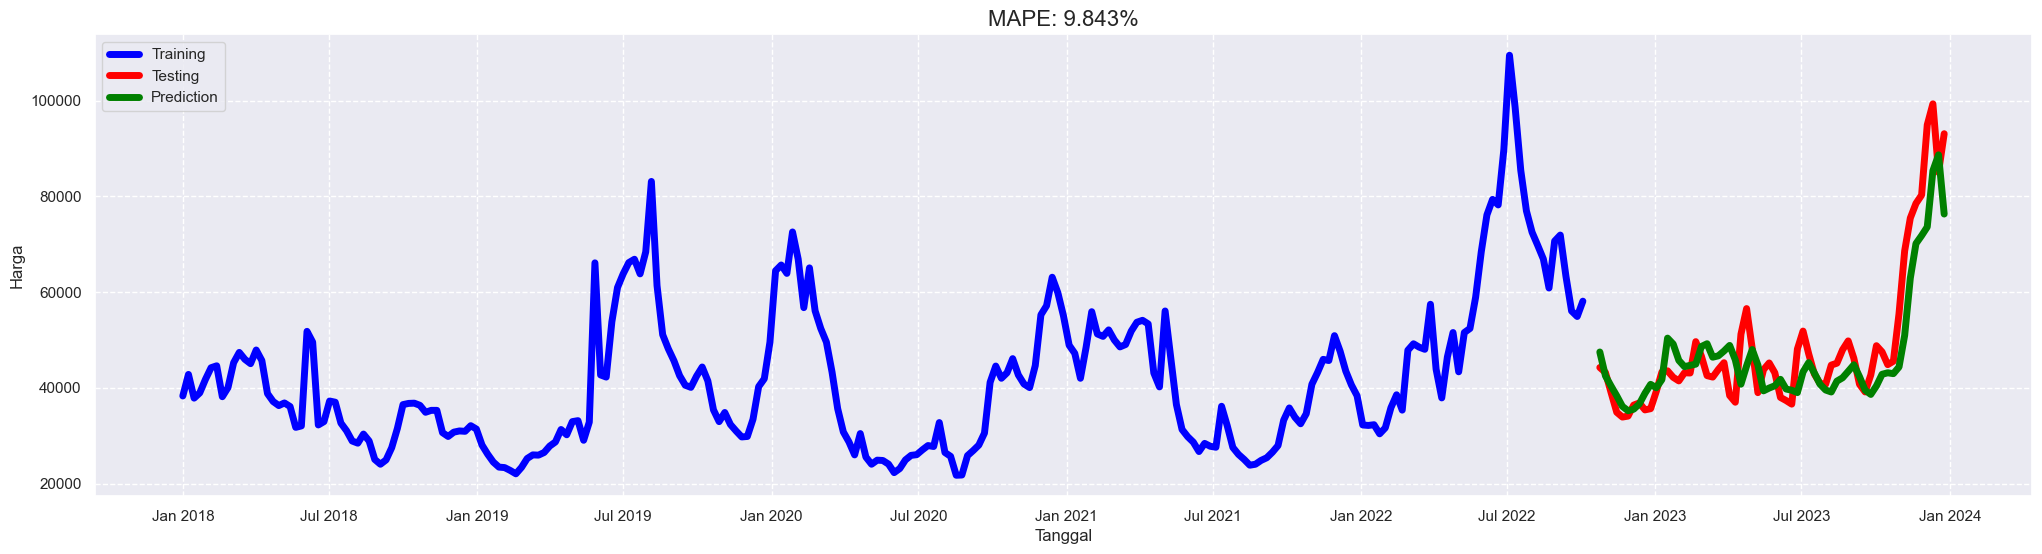

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.dates import MonthLocator, DateFormatter
mape = mean_absolute_percentage_error(testY, predictions)*100

plt.figure(figsize=(25, 6))
plt.plot(df.index[:len(trainY)], trainY, label='Training', marker='', color='blue', linestyle='-', linewidth=5)
plt.plot(df.index[-len(testY):], testY, label='Testing', marker='', color='red', linestyle='-', linewidth=5)
plt.plot(df.index[-len(predictions):], predictions, label='Prediction', marker='', color='green', linestyle='-', linewidth=5)
plt.title(f'MAPE: {mape:.3f}%', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()

locator = MonthLocator(bymonth=[1, 7])
formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.show()


In [ ]:
#import pickle

#Save the model to a pickle file
#with open('modelfix.pkl', 'wb') as f:
    #pickle.dump(model, f)